# Surface-Volume Reactions (Example: IP3 Model)

The simulation script described in this chapter is available at [STEPS_Example repository](https://github.com/CNS-OIST/STEPS_Example/blob/master/user_manual/source/ip3.ipynb).

In the [previous chapter](well_mixed.ipynb) we used objects of type [steps.model.Reac](API_model.rst#steps.model.Reac) to represent
a reaction taking place inside a volume. In this chapter we consider another
type of kinetic reaction represented by the [steps.model.SReac](API_model.rst#steps.model.SReac) class
(associated with the [steps.model.Surfsys](API_model.rst#steps.model.Surfsys) container) which defines a
reaction taking place on a `surface` (or `patch`) connecting two compartments
(arbitrarily naming one of them the “inner” compartment, and the other one
the “outer” compartment). Reactants and products can therefore be freely moving
around in a volume or embedded in a surface.
Therefore, it is necessary to firstly specify the location of the reactant
and product species.

**_Note_**: *Surface reactions are designed to represent reactions where one
   reactant is embedded in a membrane, but in fact if all reactants and
   products belong to the same compartment and none appear on a patch
   it will behave exactly like the equivalent Reac object.*

The stoichiometry of the surface reaction is specified by the following lists:

* Species on the left hand side of the reaction (the reactants):
    * Species on the surface (`slhs`).
    * Species in the “outer” compartment (`olhs`).
    * **or** Species in the “inner” compartment (`ilhs`). 

* Species on the right hand side of the reaction (the products):
    * Species on the surface (`srhs`).
    * Species in the “outer” compartment (`orhs`).
    * Species in the “inner” compartment (`irhs`).

__Note__: *Reactant species cannot belong to different compartments,
   so attempting to create an SReac object with both* `olhs` *and* `ilhs` *will
   result in an error.*

To become familiar with these objects we will build a simplified version of
the inositol 1,4,5-trisphosphate (IP $_{3}$) model
 (described in Doi T, et al,*Inositol
   1,4,5-Triphosphate-Dependent* $Ca^{\text{2+}}$ *Threshold Dynamics
   Detect Spike Timing in Cerebellar Purkinje Cells*, J Neurosci 2005, 25(4):950-961) in STEPS.
   
![](images/ip3_2.png)
 
In the IP3 receptor model, reactions (i.e. receptor binding of IP3 andcalcium molecules) take place on the membrane separating the endoplasmicreticulum (ER) and the cytosol. Therefore, we will use Surface Reaction objects to describe the reactions.
   
   
In the figure below we can see a  schematic diagram of the states
and transitions in the model. We see that our reactions take place on the
membrane between the cytosol and the Endoplasmic Reticulum (ER) and therefore
must be described by an SReac object, with each “binding” reaction described
by a second order surface reaction and each “unbinding” reaction by a first
order surface reaction.

 
![](images/IP3_schem_new.png)


We will go through the Python code to build this model in STEPS,
but providing only brief descriptions of operations we are familiar
with from the previous chapter.

## Model specification

### Model container

First we need to import the [steps.model](API_model.rst#steps.model) package and create a [steps.model.Model](API_model.rst#steps.model.Model)
container object named `mdl`, as we did in  [previous chapter](well_mixed.ipynb):


In [2]:
import steps.model as smodel
mdl = smodel.Model()

### Species

Now we create the species in this model based on the above diagram of the states and transitions,
declaring all receptor states as separate [steps.model.Spec](API_model.rst#steps.model.Spec) objects. Recall that all
identifier strings must be unique and we should also make sure not to reuse
a variable name so that we do not lose any references to the objects we create:

In [3]:
# Calcium
Ca = smodel.Spec('Ca', mdl)
# IP3
IP3 = smodel.Spec('IP3', mdl)
############### receptor state objects ###############
# receptor state: 'naive' state (no bound ligands)
R = smodel.Spec('R', mdl)

# receptor state: bound IP3
RIP3 = smodel.Spec('RIP3', mdl)

# receptor state: bound IP3 and Ca (open)
Ropen = smodel.Spec('Ropen', mdl)
# receptor state: Ca bound to one inactivation site
RCa = smodel.Spec('RCa', mdl)
# receptor state: Ca bound to two inactivation sites
R2Ca = smodel.Spec('R2Ca', mdl)
# receptor state: Ca bound to three inactivation sites
R3Ca = smodel.Spec('R3Ca', mdl)

# receptor state: Ca bound to four inactivation sites
R4Ca = smodel.Spec('R4Ca', mdl)

### Surface System

Next we create a *surface system*. The function of a surface system is similar
to the volume system used to group [steps.model.Reac](API_model.rst#steps.model.Reac) objects we saw in the [tutorial on well mixed models](well_mixed.ipynb). Basically,
surface systems group a set of reaction rules that are described
by [steps.model.SReac](API_model.rst#steps.model.SReac) objects. It is often the case that such reactions are modeled as
taking place on a membrane surface and not within a volume, although this is
actually not a necessity. We need to create an object of type
[steps.model.Surfsys](API_model.rst#steps.model.Surfsys). The arguments to the class constructor are an identifier
string and a reference to the parent [steps.model.Model](API_model.rst#steps.model.Model) object:


In [4]:
surfsys = smodel.Surfsys('ssys', mdl)

### Reactions

Now it is time to specify the reaction stoichiometry, shown in
diagram of states. Unlike in [Well-Mixed Reaction Systems](well_mixed.ipynb#well_mixed),
the reactions in this model are defined by the surface reaction objects
([steps.model.SReac](API_model.rst#steps.model.SReac)) in which the arguments include information about
which compartment or patch the reactants and products belong to. Therefore each reactant
and product of a surface reaction may be a chemical species within a volume or one which
is bound to a surface.

Therefore surface reaction objects can deal with three types of reactions, classified by the locations of the reactants, and the object is smart enough to know what type of reaction it is so that the solver knows what kind of reaction it is dealing with. The three types of reactions are;

- **Volume-Surface reactions**.   In this case molecules within a volume interact with molecules embedded in a surface and result in products that may reside within in a volume or a surface. The units for the reaction parameters in this case are the same as for ordinary volume reactions, namely: a first order reaction parameter has units $s^{-1}$; a second order reaction parameter has units $\left(M.s\right)^{-1}$; a third order reaction $\left(M^{2}.s\right)^{-1}$; and so on.

- **Surface-Surface reactions**.   In this case the reactants are all embedded in a surface. Quite clearly, the dimensions of the reaction are different from a volume reaction and the reaction parameter is assumed to be two-dimensional. This is an important point because the reaction parameter will be treated differently from a volume-volume or volume-surface interaction. A further complication is that parameters for ordinary volume reactions are based on the litre, where there is no convenient equivalent 2D concentration unit.   Surface-surface reaction parameters are based on units of area of `square meters`. **A first order surface-surface reaction parameter is therefore required in units of** $s^{-1}$; **a second-order surface-surface reaction parameter has units** $\left(mol.m^{-2}\right)^{-1}.s^{-1}$; **a third-order surface-surface reaction parameter has units** $\left(mol.m^{-2}\right)^{-2}.s^{-1}$; and so on.   Zero-order surface reactions are not supported because of the ambiguity of interpreting the reaction parameter.

- **Volume-Volume reactions**. 
   It is possible for a surface reaction to contain reactant species that are all in a volume, in which case the reaction behaves similarly to an ordinary volume reaction ([steps.model.Reac](API_model.rst#steps.model.Reac)), though products may belong to connected volumes or surfaces.


As mentioned previously, to create our surface reaction objects we have to include some information about the location of the reaction:
which compartment are the reactants to be found in, and are any molecules embedded in a surface and which of the two compartments that the surface connects are the products injected into? We supply this information to STEPS by labelling our compartments that a patch connects, arbitrarily choosing the labels 'inner' and 'outer'. When the surface reaction's parent surface system object is added to a certain patch, the compartment labelling in the surface reaction stoichiometry will match the compartment labelling in the patch definition. We will come to creating a patch later in this chapter.

So, at this stage we must chose which compartment we will label 'outer'
and which we will label 'inner' and make sure to maintain this labelling
throughout our definitions, and also in our geometry description.
We chose to label the cytosol as the 'outer' compartment and the ER
as the 'inner' compartment, so should be very careful that this ties in correctly to our description when
we create our [steps.geom.Patch](API_geom.rst#steps.geom.Patch) object to represent a surface to connect the two compartments.

We will first complete all “forward” binding reactions, recalling that
“forward” and “backward” reactions must be declared separately:


In [5]:
# The 'forward' binding reactions:
R_bind_IP3_f = smodel.SReac('R_bind_IP3_f', surfsys,
                            olhs=[IP3], slhs=[R], srhs=[RIP3])

RIP3_bind_Ca_f = smodel.SReac('RIP3_bind_Ca_f', surfsys,
                              olhs=[Ca], slhs=[RIP3], srhs=[Ropen])

R_bind_Ca_f = smodel.SReac('R_bind_Ca_f', surfsys,
                           olhs=[Ca], slhs=[R], srhs=[RCa])

RCa_bind_Ca_f = smodel.SReac('RCa_bind_Ca_f', surfsys,
                             olhs=[Ca], slhs=[RCa],srhs=[R2Ca])

R2Ca_bind_Ca_f = smodel.SReac('R2Ca_bind_Ca_f', surfsys,
                              olhs=[Ca], slhs=[R2Ca], srhs=[R3Ca])

R3Ca_bind_Ca_f = smodel.SReac('R3Ca_bind_ca_f', surfsys,
                              olhs=[Ca], slhs=[R3Ca], srhs=[R4Ca])

In [6]:
# The 'backward' unbinding reactions:
R_bind_IP3_b = smodel.SReac('R_bind_IP3_b', surfsys,
                            slhs=[RIP3], orhs=[IP3], srhs=[R])

RIP3_bind_Ca_b = smodel.SReac('RIP3_bind_Ca_b', surfsys,
                              slhs=[Ropen], orhs=[Ca], srhs=[RIP3])

R_bind_Ca_b = smodel.SReac('R_bind_Ca_b', surfsys,
                           slhs=[RCa], orhs=[Ca], srhs=[R])

RCa_bind_Ca_b = smodel.SReac('RCa_bind_Ca_b', surfsys,
                             slhs=[R2Ca], orhs=[Ca], srhs=[RCa])

R2Ca_bind_Ca_b = smodel.SReac('R2Ca_bind_Ca_b', surfsys,
                              slhs=[R3Ca], orhs=[Ca], srhs=[R2Ca])

R3Ca_bind_Ca_b = smodel.SReac('R3Ca_bind_ca_b', surfsys,
                              slhs=[R4Ca], orhs=[Ca], srhs=[R3Ca])

We model our calcium flux from the ER to the cytosol simply as a second order reaction.
In effect we are saying, when such a reaction takes place, a calcium ion from
the ER passes instantaneously through an open receptor to the cytosol.

In [7]:
# Ca ions passing through open IP3R channel
R_Ca_channel_f = smodel.SReac('R_Ca_channel_f', surfsys,\
                              ilhs=[Ca], slhs=[Ropen], orhs=[Ca], srhs=[Ropen])

We can see that it is vital that when we come to describing our geometry
that our compartment labelling is maintained. At this level we have specified
whether some reactants and products belong to the 'inner' or 'outer' compartment,
with the intention to label the cytosol as the 'outer' compartment and the ER as
the 'inner' compartment, but we will not actually make that distinction until
we come to describing our geometry.

Next, we set all reaction constants' default values (see Doi T, et al,*Inositol
   1,4,5-Triphosphate-Dependent* $Ca^{\text{2+}}$ *Threshold Dynamics
   Detect Spike Timing in Cerebellar Purkinje Cells*, J Neurosci 2005, 25(4):950-961). These constants
could have been passed to the initializer when we were creating our [steps.model.SReac](API_model.rst#steps.model.SReac) objects,
but for clarity we chose to set them here with method `setKcst`. Since these are volume-surface interactions, we must make
sure to supply our values in Molar units as  discussed previously in this chapter.


In [8]:
R_bind_IP3_f.setKcst(1000e6)
R_bind_IP3_b.setKcst(25800)
RIP3_bind_Ca_f.setKcst(8000e6)
RIP3_bind_Ca_b.setKcst(2000)
R_bind_Ca_f.setKcst(8.889e6)
R_bind_Ca_b.setKcst(5)
RCa_bind_Ca_f.setKcst(20e6)
RCa_bind_Ca_b.setKcst(10)
R2Ca_bind_Ca_f.setKcst(40e6)
R2Ca_bind_Ca_b.setKcst(15)
R3Ca_bind_Ca_f.setKcst(60e6)
R3Ca_bind_Ca_b.setKcst(20)
R_Ca_channel_f.setKcst(2e8)

## Geometry specification

The next step is to create the geometry for the model. We will chose well-mixed
geometry, as in the [chapter on well-mixed models](well_mixed.ipynb), but we now have two compartments which
are connected by a surface 'patch'. We create two [steps.geom.Comp](API_geom.rst#steps.geom.Comp) objects
to represent the Endoplasmic Reticulum (which we intend to label the 'inner'
compartment) and the cytosol ('outer' compartment), and a [steps.geom.Patch](API_geom.rst#steps.geom.Patch)
object to represent the ER membrane between the ER and cytosol.
We then add the stoichiometry we previously defined and grouped in our
surface system object to the patch object. Note that any volume-reactions we defined with `Reac` objects and grouped in `Volsys`containers would be added to the `Compartments` at this stage.

First we create the two well-mixed compartments. With more than one compartment
in the model we must make sure that the identifier strings are be unique amongst
all compartments in the geometry container. We create the cytosol compartment
with the minimum information (identifier string and reference to container),
setting the volume with class method [steps.geom.Comp.setVol](API_geom.rst#steps.geom.Comp.setVol), but set the volume of the ER during
object construction purely to demonstrate the two possible ways to achieve the task:


In [9]:
import steps.geom as swm
wmgeom = swm.Geom()

# Create the cytosol compartment
cyt = swm.Comp('cyt', wmgeom)
cyt.setVol(1.6572e-19)

# Create the Endoplasmic Reticulum compartment
ER = swm.Comp('ER', wmgeom, vol=1.968e-20)

We now create a [steps.geom.Patch](API_geom.rst#steps.geom.Patch) object, defining the 'inner' and 'outer' compartments.
We wish to label the ER as the 'inner' compartment and the cytosol as the 'outer' compartment,
which we achieve by their order to the patch object constructor.
The 3rd (required) argument to the constructor (here I am calling the string Id the 1st argument, not the 'zeroth') is a reference to the 'inner'
compartment and the 4th (optional) argument is a reference to the 'outer'
compartment. It is vital that care is taken in the order of the [steps.geom.Comp](API_geom.rst#steps.geom.Comp) objects to the constructor, so that the required labelling from or surface reaction
definitions is maintained. **Note**: *A Patch must have an inner compartment by convention,
   but does not require an outer compartment. This is an easy way to remember the order to the constructor; since an inner compartment is always required it must come first to the constructor, and the optional outer compartment comes after. Obviously any surface reaction
   rules that contain reactants or products in the outer compartment cannot be
   added to a Patch that doesn't have an outer compartment.*

We can check the labelling is as desired after
object construction if we like with methods [steps.geom.Patch.getOComp](API_geom.rst#steps.geom.Patch.getOComp) and [steps.geom.Patch.getIComp](API_geom.rst#steps.geom.Patch.getIComp). **Note**: *Typically, get functions return references to the object, not the identifier
   string, so we can use any of the object methods on the returned reference to
   access information about the object. Here we use method getID, which returns
   the identifier string of the object.*

We also set the surface area of the patch:


In [10]:
# ER is the 'inner' compartment, cyt is the 'outer' compartment
memb = swm.Patch('memb', wmgeom, ER, cyt)
memb.addSurfsys('ssys')
memb.setArea(0.4143e-12)

In [11]:
from __future__ import print_function # for backward compatibility with Py2

print('Inner compartment to memb is', memb.getIComp().getID())
print('Outer compartment to patch is', memb.getOComp().getID())

Inner compartment to memb is ER
Outer compartment to patch is cyt


## Simulation with `Wmdirect`

Now the model is completed and ready for simulation. To run the simulation,
we create a random number generator object, as we did previously in
[Well-Mixed Reaction Systems](well_mixed.ipynb#well_mixed):

In [12]:
import steps.rng as srng
r = srng.create('mt19937', 512)
r.initialize(7233)

and use the [steps.solver.Wmdirect](API_solver.rst#steps.solver.Wmdirect) solver as we also did in [Well-Mixed Reaction Systems](well_mixed.ipynb#well_mixed):


In [13]:
import steps.solver as ssolver
sim = ssolver.Wmdirect(mdl, wmgeom, r)

To run the simulation and plot the data, we import modules from `numpy` 
and create arrays to store the data, as we also did previously. We also import modules from `matplotlib` in order to plot the results. This time we also want to plot the standard deviation so we
create arrays to store that data too. Here we create variable `NITER`
and assign it the value 100, the number of iterations we wish to run. **Note**: *It is perhaps better to group simulation parameters together at the
   beginning of the script (such as number of iterations, simulation end time,
   data collection time step, etc) so we can change a parameter simply by
   changing one variable, which reduces the amount of typing and reduces the
   scope for error. This is an approach we will adopt in the* [next chapter](diffusion.ipynb).


In [14]:
NITER = 100
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
tpnt = np.arange(0.0, 0.201, 0.001)
res = np.zeros([NITER, 201, 2])
res_std = np.zeros([201, 2])
res_std1 = np.zeros([201, 2])
res_std2 = np.zeros([201, 2])

At the beginning of the simulation, we reset the solver state and set the
initial concentration or count (by “count” we mean the number of molecules)
of each species (any species we don't explicitly assign a concentration or
count to will be initialized with the default value of zero which was set
when we called the reset function) and run the simulation for `NITER` number
of iterations. In the following example code, we record the number of IP3
receptors in open state ('Ropen' in 'memb') and the concentration of calcium
in the cytosol ('Ca' in 'cyt'). We include a `pylab.plot` call within our main
loop to plot the number of open receptors for each individual iteration:


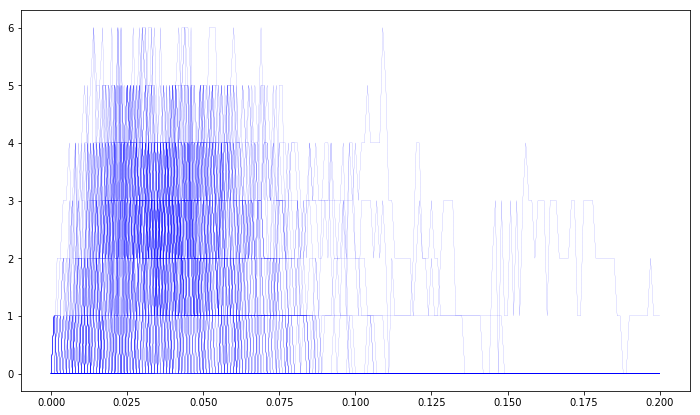

In [18]:
plt.figure(figsize=(12,7))
for i in range (0, NITER):
    sim.reset()
    sim.setCompConc('cyt', 'Ca', 3.30657e-8)
    sim.setCompCount('cyt', 'IP3', 6)
    sim.setCompConc('ER', 'Ca', 150e-6)
    sim.setCompClamped('ER', 'Ca', True)
    sim.setPatchCount('memb', 'R', 160)
    for t in range(0, 201):
        sim.run(tpnt[t])
        res[i, t, 0] = sim.getPatchCount('memb', 'Ropen')
        res[i, t, 1] = sim.getCompConc('cyt', 'Ca')
    plt.plot(tpnt, res[i,:,0], color='blue', linewidth=0.1)

We can also calculate the mean and standard deviation of our data using
NumPy functions and plot them.

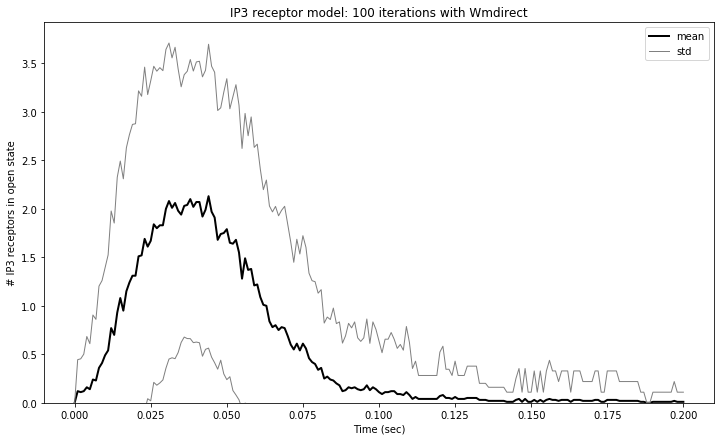

In [21]:
plt.figure(figsize=(12,7))
res_mean = np.mean(res, 0)
res_std = np.std(res, 0)
res_std1 = res_mean[:,0] + res_std[:,0]
res_std2 = res_mean[:,0]- res_std[:,0]

plt.plot(tpnt, res_mean[:,0], color='black', linewidth=2.0, label='mean')
plt.plot(tpnt, res_std1, color='gray', linewidth=1.0, label='std')
plt.plot(tpnt, res_std2,color='gray', linewidth=1.0)

plt.xlabel('Time (sec)')
plt.ylabel('# IP3 receptors in open state')
plt.title('IP3 receptor model: %d iterations with Wmdirect' % NITER)
plt.ylim(0)
plt.legend()